# Implementation of N. C. Ristea et al. 2022 - GUIDED DEEP LEARNING BY SUBAPERTURE DECOMPOSITION: OCEAN PATTERNS FROM SAR IMAGERY

## Loading the data

In [2]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt

data_folder = "data"
rain_cell_image_name = "rain_cell.tiff"
icebergs_image_name = "icebergs.tiff"


# Load the images using Image.open()
rain_cell_path = os.path.join(data_folder, rain_cell_image_name)
icebergs_path = os.path.join(data_folder, icebergs_image_name)

rain_cell = np.array(Image.open(rain_cell_path))
icebergs = np.array(Image.open(icebergs_path))

print(f"Rain cell image size: {rain_cell.size}")
print(f"Icebergs image size: {icebergs.size}")

Rain cell image size: 276433
Icebergs image size: 278810


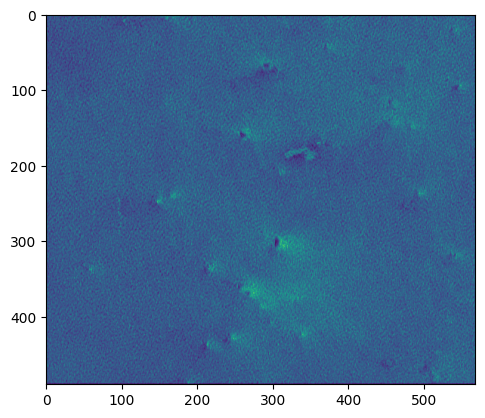

In [3]:
im = icebergs

plt.imshow(im)
plt.show()

In [47]:
def db(x, eps=1e-10):
    return 20*np.log(np.abs(x) + eps)

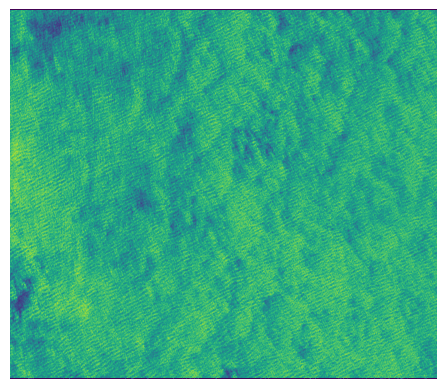

(4920, 5681)
261.65417


In [48]:
import numpy as np, tifffile as tiff, matplotlib.pyplot as plt

data_folder_name = "data"
folder_name = "sentinel_images.SAFE"
measurements_folder = "measurement"
annotations_folder = "annotation"


calibration_folder = "calibration"

# image 9
slc_image_name = "s1c-wv1-slc-vv-20250907t201911-20250907t201914-004023-007ffa-009.tiff"
image_calibration_name = "calibration-s1c-wv1-slc-vv-20250907t201911-20250907t201914-004023-007ffa-009.xml"
image_annotations_name = "s1c-wv1-slc-vv-20250907t201911-20250907t201914-004023-007ffa-009.xml"

# image 
# slc_image_name = "s1c-wv1-slc-vv-20250907t201714-20250907t201717-004023-007ffa-001.tiff"
# image_calibration_name = "calibration-s1c-wv1-slc-vv-20250907t201714-20250907t201717-004023-007ffa-001.xml"
# image_annotations_name = "s1c-wv1-slc-vv-20250907t201714-20250907t201717-004023-007ffa-001.xml"

im_path = os.path.join(data_folder_name, folder_name, measurements_folder, slc_image_name)
calibration_path = os.path.join(data_folder_name, folder_name, annotations_folder, calibration_folder, image_calibration_name)
annotations_path = os.path.join(data_folder_name, folder_name, annotations_folder,image_annotations_name)

arr = tiff.imread(im_path)

# S1 SLC may come as complex dtype OR as two samples per pixel (I,Q)
if np.iscomplexobj(arr):
    z = arr
elif arr.ndim == 3 and arr.shape[-1] == 2:   # (..., 2) = I,Q
    z = arr[...,0].astype(np.float32) + 1j*arr[...,1].astype(np.float32)
else:
    raise RuntimeError(f"Unexpected TIFF shape/dtype: {arr.shape}, {arr.dtype}")

amp_db = db(z)
vmin, vmax = np.percentile(amp_db, (2, 98))
plt.imshow(amp_db, vmin=vmin, vmax=vmax); plt.axis("off"); plt.show()

print(arr.shape)

print(np.mean(np.abs(z)))


## σ0 calibration


In [49]:
# ------------------------------------
# Computation of σ0 before calibration
# ------------------------------------


from pathlib import Path
import numpy as np
import rasterio as rio
from lxml import etree

# 1) pick the complex SLC measurement (WV/IW/EW all similar)
meas_tif = im_path

# 2) pick the matching calibration XML for this swath/pol
cal_xml = calibration_path

# --- load complex SLC and make intensity ---
with rio.open(meas_tif) as src:
    z = src.read(1)                # complex64
    intensity = (z.real**2 + z.imag**2).astype("float32")



root = etree.parse(str(cal_xml)).getroot()

cal_vecs = root.findall(".//calibrationVector")

pix_idx  = np.fromstring(cal_vecs[0].findtext("pixel"), sep=" ", dtype=np.float32)
print(f"Column indexes with a sigmaNaught value:{pix_idx}")

lines_idx = np.array([int(v.findtext("line")) for v in cal_vecs], dtype=np.float32)

print(f"Line indexes with a sigmaNaught value:{lines_idx}")

sigma_rows = [np.fromstring(v.findtext("sigmaNought"), sep=" ", dtype=np.float32)
              for v in cal_vecs]


sigma_rows = np.stack(sigma_rows, axis=0)  # (nVec, nPixTie)

H, W = intensity.shape



# Interpolating along range direction
cols = np.arange(W, dtype=np.int32)

sigma_range = np.stack([np.interp(cols, pix_idx, row) for row in sigma_rows], axis=0)

rows = np.arange(H, dtype=np.int32)


# interpolating along awimut direction
sigma_2d_naught = np.empty((H, W), dtype=np.float32)
for c in range(W):
    sigma_2d_naught[:, c] = np.interp(rows,
                               lines_idx.astype(np.float32),
                               sigma_range[:, c])
    
print("np.mean(sigma_2d_naught)", np.mean(sigma_2d_naught))
print("np.mean(intensity)", np.mean(intensity))
# --- apply your paper’s formula ---

print(np.mean(np.maximum(sigma_2d_naught**2, 1e-20)), "np.mean(np.maximum(sigma_2d_naught**2, 1e-20))")
print(np.mean(intensity), "intensity")

sigma0 = intensity / np.maximum(sigma_2d_naught**2, 1e-20)  # linear σ⁰


Column indexes with a sigmaNaught value:[   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.  520.  560.  600.  640.  680.  720.  760.  800.  840.  880.  920.
  960. 1000. 1040. 1080. 1120. 1160. 1200. 1240. 1280. 1320. 1360. 1400.
 1440. 1480. 1520. 1560. 1600. 1640. 1680. 1720. 1760. 1800. 1840. 1880.
 1920. 1960. 2000. 2040. 2080. 2120. 2160. 2200. 2240. 2280. 2320. 2360.
 2400. 2440. 2480. 2520. 2560. 2600. 2640. 2680. 2720. 2760. 2800. 2840.
 2880. 2920. 2960. 3000. 3040. 3080. 3120. 3160. 3200. 3240. 3280. 3320.
 3360. 3400. 3440. 3480. 3520. 3560. 3600. 3640. 3680. 3720. 3760. 3800.
 3840. 3880. 3920. 3960. 4000. 4040. 4080. 4120. 4160. 4200. 4240. 4280.
 4320. 4360. 4400. 4440. 4480. 4520. 4560. 4600. 4640. 4680. 4720. 4760.
 4800. 4840. 4880. 4920. 4960. 5000. 5040. 5080. 5120. 5160. 5200. 5240.
 5280. 5320. 5360. 5400. 5440. 5480. 5520. 5560. 5600. 5640. 5680.]
Line indexes with a sigmaNaught value:[   0. 1650. 3300. 4951. 6601.]
np.mean(sigma_2d_na

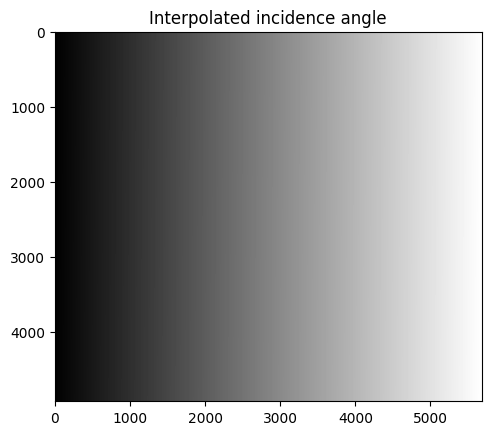

In [32]:
# -----------------------------------
# Computation of the incidence angles
# -----------------------------------


import numpy as np
from lxml import etree
from scipy.interpolate import griddata

# Parse XML
tree = etree.parse(annotations_path)
pts = tree.findall(".//geolocationGridPoint")

# Collect tie point data
lines   = np.array([int(p.findtext("line")) for p in pts])
pixels  = np.array([int(p.findtext("pixel")) for p in pts])
theta   = np.array([float(p.findtext("incidenceAngle")) for p in pts])

# Target full grid
H, W = intensity.shape  # rows, cols of your SLC
grid_lines, grid_pixels = np.mgrid[0:H, 0:W]

# Interpolate incidence angle to full grid
theta_map = griddata(
    points=(lines, pixels),
    values=theta,
    xi=(grid_lines, grid_pixels),
    method="linear"
)

plt.title("Interpolated incidence angle")
plt.imshow(theta_map, cmap="grey")
plt.show()


theta_map.shape (4920, 5681) phi_map.shape (4920, 5681) v_map.shape (4920, 5681)


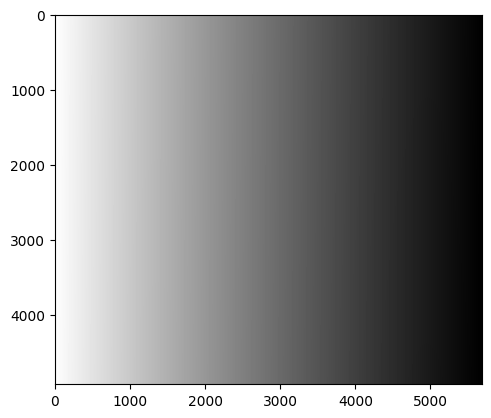

In [33]:
# ------------------------------------
# σ0 calibration
# -----------------------------------

# Wind speed is considered constant everywhere = 10 m/s
# Wind relative angle with azimut direction is taken as 45 degrees
phi = 45
phi_map = np.ones((H, W)) * phi

v = 10
v_map = np.ones((H, W)) * v

print("theta_map.shape",theta_map.shape, "phi_map.shape", phi_map.shape, "v_map.shape", v_map.shape)


# Download from: openwind/openwind/cmod5n.py on GitHub
import numpy as np
from cmod5n import cmod5n_forward  # function name may vary

# Given your geometry and constants:
# theta (incidence angle, degrees) as a NumPy array
# phi (wind-relative look, degrees) as same-shape array
# fixed U10 = 10.0 m/s

reference_factor = cmod5n_forward(v=v_map, phi=phi_map, theta=theta_map)  # returns linear σ⁰ reference map

plt.imshow(reference_factor, cmap="grey")
plt.show()

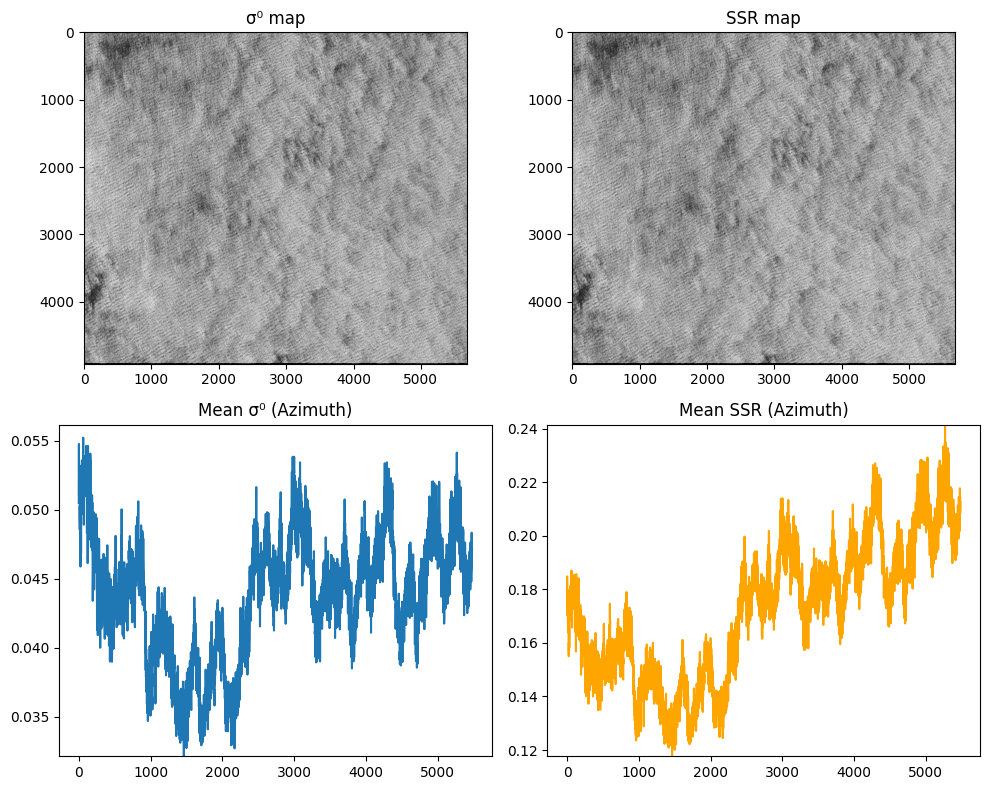

In [52]:
mean_sigma0_along_azimut = np.mean(sigma0, axis=0)
mean_ssr_along_azimut = np.mean(ssr, axis=0)
mean_intensity = np.mean(intensity, axis=0)
# print(np.min(mean_ssr_along_azimut))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

db_sigma0 = db(sigma0)
vmin_sigma0, vmax_sigma0 = np.percentile(db_sigma0, (2, 98))

db_ssr = db(ssr)
vmin_ssr, vmax_ssr = np.percentile(db_ssr, (2, 98))


axes[0,0].imshow(db_sigma0, vmin=vmin_sigma0, vmax=vmax_sigma0, cmap="gray")
axes[0,0].set_title("σ⁰ map")

axes[0,1].imshow(db_ssr, vmin=vmin_ssr, vmax=vmax_ssr, cmap="gray")
axes[0,1].set_title("SSR map")

# Plot the 1D profiles
axes[1,0].plot(mean_sigma0_along_azimut[100:-100], label="σ⁰")
axes[1,0].set_title("Mean σ⁰ (Azimuth)")

axes[1,1].plot(mean_ssr_along_azimut[100:-100], label="SSR", color="orange")
axes[1,1].set_title("Mean SSR (Azimuth)")



# --- Force same vertical scale
min_sigma0_mean = mean_sigma0_along_azimut.min()
max_sigma0_mean = mean_sigma0_along_azimut.max()
min_ssr_mean = mean_ssr_along_azimut.min()
max_ssr_mean = mean_ssr_along_azimut.max()

ymin = min(min_sigma0_mean, min_ssr_mean)
ymax = max(max_sigma0_mean, max_ssr_mean)

axes[1,0].set_ylim(min_sigma0_mean, max_sigma0_mean)
axes[1,1].set_ylim(min_ssr_mean, max_ssr_mean)

plt.tight_layout()
plt.show()

In [53]:
im = ssr

## Azimut FFT
    After σ0 calibration, we perform the Fast Fourier Transform (FFT) along the azimuth axis, in order to obtain the vignette’s spectrum. The number of FFT points is equal to the number of points in the azimuth direction.

In [54]:
from numpy import fft


N = im.shape[0]
azimut_spectrum = fft.fftshift(fft.fft(im, n=N, axis=0), 0)
f = fft.fftshift(fft.fftfreq(N, d=1))



In [55]:
# getting Delta time of acquisition
tree = etree.parse(annotations_path)
root = tree.getroot()

start_time = root.find(".//adsHeader/startTime").text
stop_time  = root.find(".//adsHeader/stopTime").text


print(start_time, stop_time)

from datetime import datetime

fmt = r"%Y-%m-%dT%H:%M:%S.%f"
t_start = datetime.strptime(start_time, fmt)
t_stop  = datetime.strptime(stop_time, fmt)

delta = t_stop - t_start
Dt = delta.total_seconds()

print("Difference:", delta)
print("Seconds:", Dt)

2025-09-07T20:19:11.667810 2025-09-07T20:19:14.648719
Difference: 0:00:02.980909
Seconds: 2.980909


In [56]:
# computing frequency units

df = 1/Dt

f_max = df*N/2
f_min = -df*N/2



## Hamming window compensation
    Next, we perform a Hamming window compensation, with a coefficient of 0.75, in order to obtain a flat azimuth spectrum.


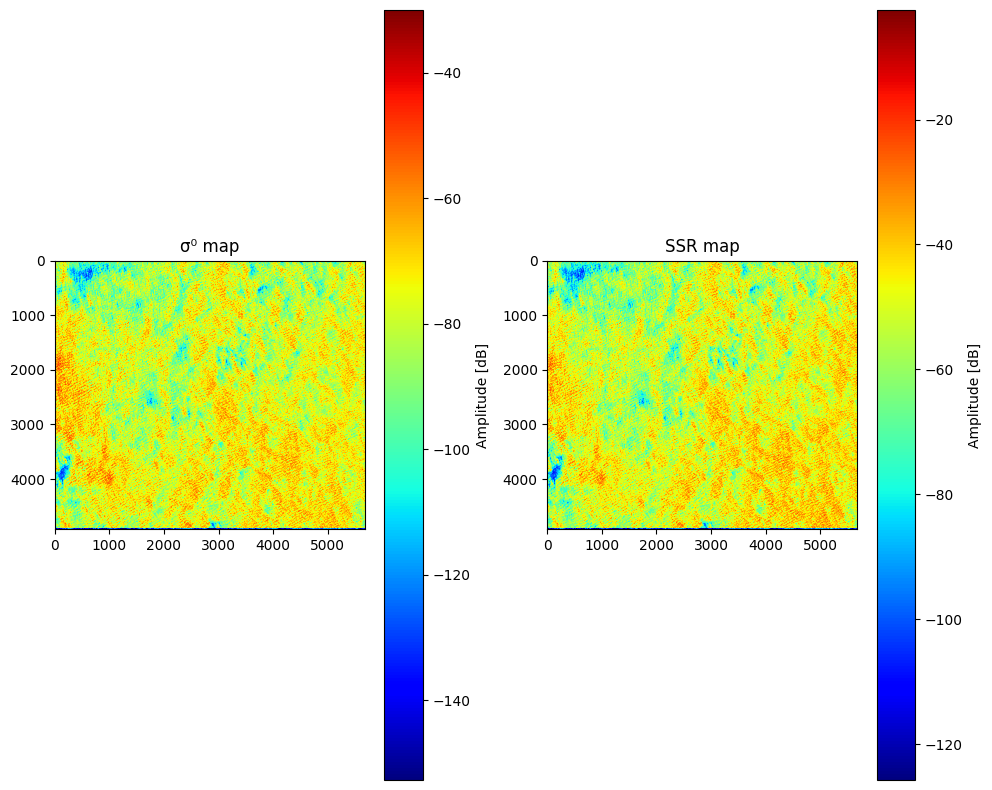

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

db_sigma0 = db(sigma0)
vmin_sigma0, vmax_sigma0 = np.percentile(db_sigma0, (2, 98))

db_ssr = db(ssr)
vmin_ssr, vmax_ssr = np.percentile(db_ssr, (2, 98))

# Plot sigma0
im0 = axes[0].imshow(db_sigma0, vmin=vmin_sigma0, vmax=vmax_sigma0, cmap="jet")
axes[0].set_title("σ⁰ map")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Amplitude [dB]")

# Plot SSR
im1 = axes[1].imshow(db_ssr, vmin=vmin_ssr, vmax=vmax_ssr, cmap="jet")
axes[1].set_title("SSR map")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Amplitude [dB]")

plt.tight_layout()
plt.show()



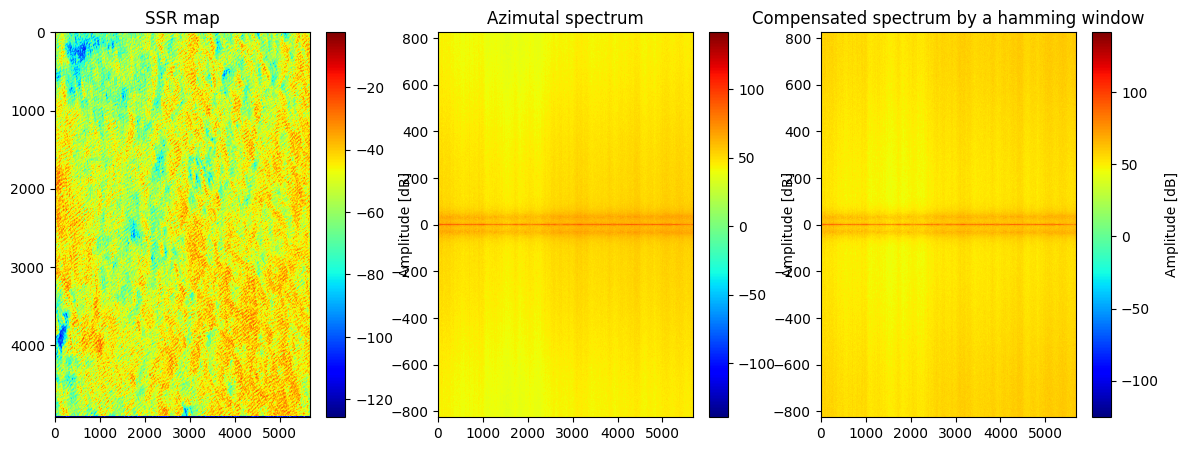

In [58]:
# Window definition

def hamming_window(N: int, coeff: float = 0.75):

    n = np.arange(-N/2, N//2)

    w = coeff + (1-coeff)*np.cos(2 * np.pi * n/(N-1))

    return w

db_azimut_spectrum = db(azimut_spectrum)
vmin_db_azimut_spectrum, vmax_db_azimut_spectrum = np.percentile(db_azimut_spectrum, (2, 98))

w = hamming_window(N, 0.75)
w = w.reshape(-1, 1)

compensated_spectrum = azimut_spectrum / w
db_compensated_spectrum = db(compensated_spectrum)

fig, axes = plt.subplots(1, 3, figsize=(14,5))

# plot ssr
im0 = axes[0].imshow(db_ssr, vmin=vmin_ssr, vmax=vmax_ssr, cmap="jet", aspect="auto")
axes[0].set_title("SSR map")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Amplitude [dB]")

axes[1].set_title("Azimutal spectrum")
im1 = axes[1].imshow(db_azimut_spectrum,extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Amplitude [dB]")


axes[2].set_title("Compensated spectrum by a hamming window")
im2 = axes[2].imshow(db_compensated_spectrum, extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")
cbar2 = fig.colorbar(im2, ax=axes[2])
cbar2.set_label("Amplitude [dB]")  # or "dB", depending on your data
plt.show()







## Subaperture generation

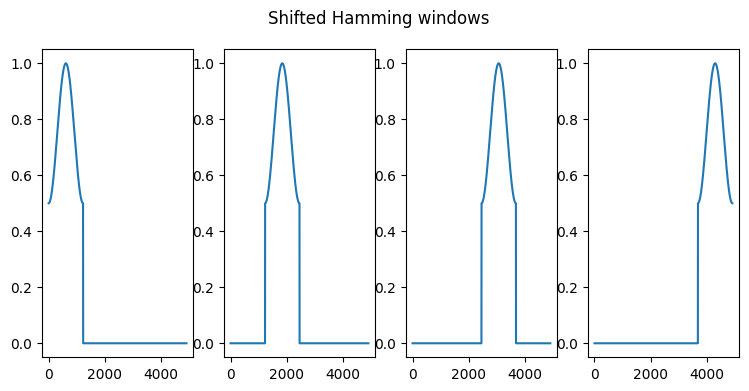

In [59]:
w_size = N//4

w = hamming_window(N//4, 0.75)
w = w.reshape(-1, 1)

# plt.plot(w)
# plt.show()

fig, axes = plt.subplots(1,4, figsize=(9,4))

fig.suptitle("Shifted Hamming windows")

pad_before = 0
pad_after  = N - w_size - pad_before
w1 = np.pad(w, ((pad_before, pad_after), (0, 0)), mode="constant")
axes[0].plot(w1)


pad_before = w_size
pad_after  = N - w_size - pad_before
w2 = np.pad(w, ((pad_before, pad_after), (0, 0)), mode="constant")
axes[1].plot(w2)


pad_before = w_size*2
pad_after  = N - w_size - pad_before
w3 = np.pad(w, ((pad_before, pad_after), (0, 0)), mode="constant")
axes[2].plot(w3)


pad_after  = 0
pad_before = N-pad_after-w_size
w4 = np.pad(w, ((pad_before, pad_after), (0, 0)), mode="constant")
axes[3].plot(w4)

plt.show()

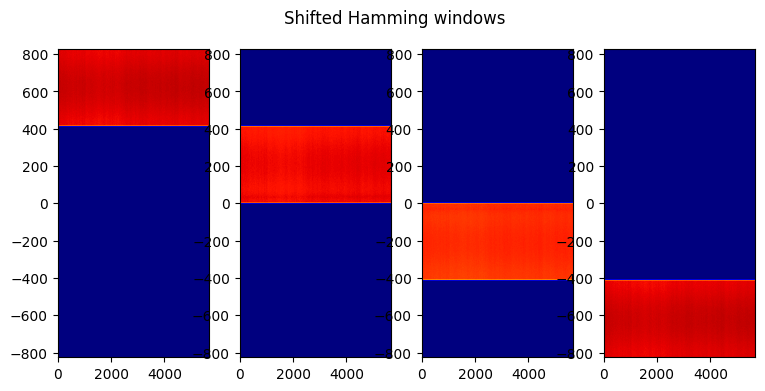

In [60]:
sp1 = w1 * compensated_spectrum
sp2 = w2 * compensated_spectrum
sp3 = w3 * compensated_spectrum
sp4 = w4 * compensated_spectrum


fig, axes = plt.subplots(1,4, figsize=(9,4))

fig.suptitle("Shifted Hamming windows")


sp1_db = db(sp1)
axes[0].imshow(sp1_db, extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")

sp2_db = db(sp2)
axes[1].imshow(sp2_db, extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")

sp3_db = db(sp3)
axes[2].imshow(sp3_db, extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")

sp4_db = db(sp4)
axes[3].imshow(sp4_db, extent=[0, azimut_spectrum.shape[1], f_min, f_max], cmap='jet', aspect="auto")

plt.show()

## Azimut iFFT

In [66]:
ifft1 = fft.ifft(sp1, n=N, axis=0)
sub1 = np.abs(ifft1)

ifft2 = fft.ifft(sp2, n=N, axis=0)
sub2 = np.abs(ifft2)

ifft3 = fft.ifft(sp3, n=N, axis=0)
sub3 = np.abs(ifft3)

ifft4 = fft.ifft(sp4, n=N, axis=0)
sub4 = np.abs(ifft4)

subs = [sub1, sub2, sub3, sub4]



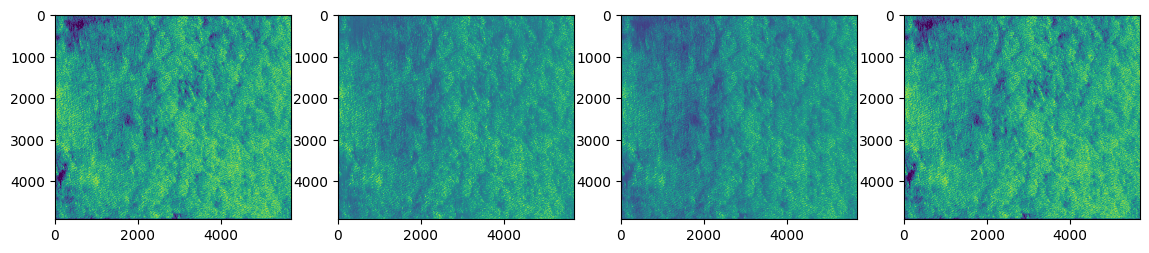

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(14,7))

for i, sub in enumerate(subs):
    sub_db = db(sub)
    vmin, vmax= np.percentile(sub_db, (2, 98))
    ax[i].imshow(sub_db, vmin=vmin, vmax=vmax)

plt.show()

## Filtering

In [ ]:
from scipy.signal import convolve2d

intensity_images = [sub**2 for sub in subs]

win_size = 10
window = np.ones((win_size,win_size)) / (win_size**2)

filtered_images = [convolve2d(im, window, mode="same", boundary="symm") for im in intensity_images]


## Decimation

In [76]:
decimated_images = [im[::10, ::10] for im in filtered_images]

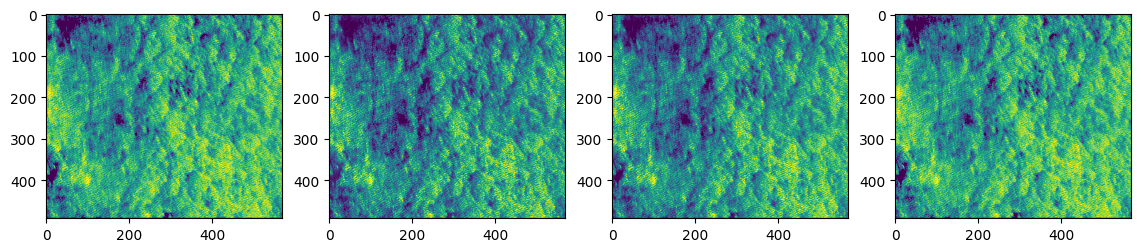

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(14,7))

for i, sub in enumerate(decimated_images):
    sub_db = db(sub)
    vmin, vmax= np.percentile(sub_db, (2, 98))
    ax[i].imshow(sub_db, vmin=vmin, vmax=vmax)

plt.show()